In [1]:
from clrs._src.algorithms.graphs import bfs

In [3]:
import numpy as np
import networkx as nx

In [45]:
import numpy as np
import networkx as nx
from clrs._src.algorithms.graphs import bfs
import matplotlib.pyplot as plt

class graph_generator:
    def __init__(self, n, p, directed=False, type='erdos_renyi'):
        self.n = n # number of nodes
        self.p = p # probability of edge creation
        self.s = np.random.randint(0, n) # source node
        if type == 'erdos_renyi':
            self.graph = nx.erdos_renyi_graph(n, p, directed=directed)
        self.adj = nx.to_numpy_array(self.graph)
        self.edges_indexes = self.get_edges_indexes(self.adj)

        self.pi, probes = bfs(self.adj, self.s)
        self.pi_h = probes['hint']['node']['pi_h']['data']
        self.reach_h = probes['hint']['node']['reach_h']['data']

        self.pi = self.get_edges(self.adj, self.pi)
        self.pi_h = np.array([self.get_edges(self.adj, x) for x in self.pi_h])
        self.pos = np.arange(0, n)/n

    def get_edges_indexes(self, A):
        edge_indexes = [[],[]]
        """Create a 2x1 list of lists to store the indexes of the edges in the adjacency matrix."""
        for i in range(len(A)):
            for j in range(len(A)):
                if A[i][j] == 1:
                    edge_indexes[0].append(i)
                    edge_indexes[1].append(j)
        return edge_indexes
    
    def get_edges(self, A, pi):
        """Returns a binary list of edges in the graph. If the edge was accessed by the algorithm, it is marked as 1, otherwise it is 0."""
        edge_indexes = self.get_edges_indexes(A)
        edges = np.zeros(len(edge_indexes[0]))
        for i in range(len(pi)):
            if pi[i] != -1:
                for j in range(len(edge_indexes[0])):
                    if edge_indexes[1][j] == i and edge_indexes[0][j] == pi[i]:
                        edges[j] = 1
        return edges
    
    def visualize_graph(self):
        nx.draw(self.graph, with_labels=True, font_weight='bold')
        plt.show()
        

In [46]:
# test class graph_generator
n = 4
p = 0.3
g = graph_generator(n, p)

In [47]:
g.pos

array([0.  , 0.25, 0.5 , 0.75])

In [31]:
g.pi

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0.])

In [38]:
g.visualize_graph()

AttributeError: 'graph_generator' object has no attribute 'visualize_graph'

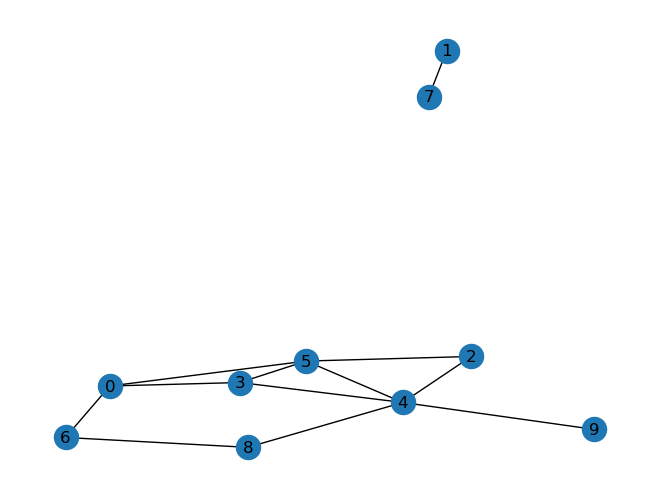

In [33]:
# visualize graph
import matplotlib.pyplot as plt
nx.draw(g.graph, with_labels=True)
plt.show()

In [34]:
g.reach_h

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 1., 1., 0., 1., 1.]])

In [4]:
# genearte random er graph
n = 10
p = 0.3
G = nx.erdos_renyi_graph(n, p)

# get the adjacency matrix
A = nx.to_numpy_array(G)

In [5]:
print(A)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [11]:
# apply bfs
s = 0
pi, probes = bfs(A, s)
pi, hints = pi, probes['hint']['node']['pi_h']['data']

In [12]:
probes

{'input': {'node': {'pos': {'data': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'type_': 'scalar'},
   's': {'data': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'type_': 'mask_one'}},
  'edge': {'A': {'data': array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 1., 1., 0., 0., 1., 1., 1., 0.],
           [1., 1., 0., 1., 0., 0., 1., 1., 0., 0.],
           [0., 1., 1., 0., 1., 0., 1., 0., 0., 0.],
           [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1., 0., 1., 0., 1., 0.],
           [0., 1., 1., 1., 0., 1., 0., 0., 0., 1.],
           [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
           [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]),
    'type_': 'scalar'},
   'adj': {'data': array([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
           [0., 1., 1., 1., 0., 0., 1., 1., 1., 0.],
           [1., 1., 1., 1., 0., 0., 1., 1., 0., 0.],
           [0., 1., 1., 1., 1., 0., 1

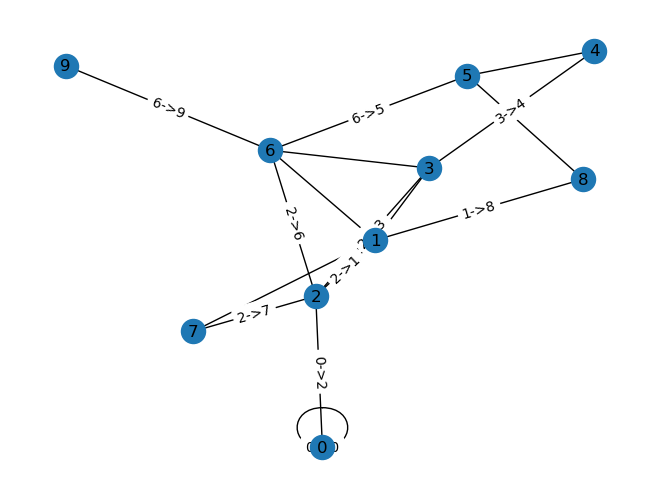

In [28]:
def visualize_bfs_tree(A, pi):
    G = nx.from_numpy_array(A)
    edges = [(pi[i], i) for i in range(len(pi)) if pi[i] != -1]
    G.add_edges_from(edges)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(pi[i], i): f'{pi[i]}->{i}' for i in range(len(pi)) if pi[i] != -1})
    return G

visualize_bfs_tree(A, pi)

In [8]:
def bfs_mod(A, s):
    # apply bfs but pi + hints (each step result)
    n = len(A)
    hints = []
    # use bfs 
    for i in range(n):  
        bfs__ = bfs(A, i)
        pi, probes = bfs__
        hints.append((pi))
    return hints

hints = bfs_mod(A, s)

In [9]:
def get_edges_indexes(A):
    edge_indexes = [[],[]]
    """Create a 2x1 list of lists to store the indexes of the edges in the adjacency matrix."""
    for i in range(len(A)):
        for j in range(len(A)):
            if A[i][j] == 1:
                edge_indexes[0].append(i)
                edge_indexes[1].append(j)
    return edge_indexes

In [10]:
def get_edges(A, pi):
    edge_indexes = get_edges_indexes(A)
    edges = np.zeros(len(edge_indexes[0]))
    for i in range(len(pi)):
        if pi[i] != -1:
            for j in range(len(edge_indexes[0])):
                if edge_indexes[1][j] == i and edge_indexes[0][j] == pi[i]:
                    edges[j] = 1
    return edges

In [157]:
# test the function
pi = [0, 0, 6, 0, 4, 5, 0, 7, 8, 9]
edges = get_edges(A, pi)
print(edges)

[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [72]:
# genearte random er graph
n = 10
p = 0.3
G = nx.erdos_renyi_graph(n, p)

# get the adjacency matrix
A = nx.to_numpy_array(G)

# apply bfs
s = 0
pi, hints = bfs(A, s)